In [1]:
import pandas as pd
import numpy as np
import ot
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sn
from pathlib import Path
from sklearn.utils import check_random_state
from scipy.spatial.distance import cdist
# User functions
from utils import BaseTransport, calc_parsimony

In [2]:
# Experiment hyperparamters
rng = np.random.RandomState(42)

In [3]:
# Setting so that the plots look normal even when using dark-reader
sn.set_style("whitegrid")
sn.set_context(context="paper", font_scale=2)
pal = sn.color_palette("Set1")

# Setting up specifics for plotting + saving
save_figures = True
add_legend = False
add_title = False
add_axis = False
save_parms = {'format': 'pdf','bbox_inches':'tight', 'pad_inches':0}
line_parms = {'linewidth':4, 'color':'k'}
if save_figures:  # saves all figures in a figure directory in the local directory
    figure_dir = Path('.') / 'figures' / 'adult-income-experiment'
    if not figure_dir.exists():
        figure_dir.mkdir(parents=True)

## Loading and Preprocessing the data


In [5]:
from data_utils import load_and_preprocess_nba_data
continuous_variables_indicies = [0,1,2]
# n_samples = 'balanced'
# n_samples = 1000
parameters_path = './Source_Target/experiment_parameters_GSW_vs_POR.csv'
X, Y, feature_names = load_and_preprocess_nba_data(parameters_path, rng, return_column_names=True)
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
print(X)
print(Y)
parameters = pd.read_csv(parameters_path)
split_on = parameters['split_feature'].values[0]
instance_1 = parameters['instance_1'].values[0]
instance_2 = parameters['instance_2'].values[0]


Splitting on Team with GSW and POR resulting source shape: (132, 3), target shape: (132, 3).
###############################
['Age', 'GamesPlayed', 'NetScoreOfPlayer']
###############################
######################## Source_Data_A Dropped ##########################
     Age  GamesPlayed  NetScoreOfPlayer
56    27           17               192
83    31           21                69
19    29           19               109
31    35           21                69
76    31           22                34
..   ...          ...               ...
71    24           24                43
106   25           12                52
14    32           22                41
92    26            5                -3
102   34            6               -29

[132 rows x 3 columns]
########################### Source_Data_B Dropped #######################
     Age  GamesPlayed  NetScoreOfPlayer
198   27            3               -14
109   37            6               -16
87    27            9       

## Performing Clustering

In [6]:
def get_mixed_variable_desiderata(X_continuous, Y_continuous, Z, standardizer, continuous_variables_indicies,
                                  n_expectation=10, inter=None, rng=None):
    rng = check_random_state(rng)
    non_continuous_variables_indicies = np.delete(np.arange(X.shape[1]), continuous_variables_indicies)
    fids = np.zeros(n_expectation)
    pars = np.zeros(n_expectation)
    for loop_idx in range(n_expectation):
        # since Z is in a pseudo continuous space, we project it to a discrete space using the phase change graph defined within Z
        # since the Z[i, j_descrete] is probability of that point being positive
        Z_projected_discrete = Z.copy()
        uniform_vars = rng.uniform(size=(Z.shape[0], len(non_continuous_variables_indicies)))
        positive_probability = Z[:, non_continuous_variables_indicies]
        Z_projected_discrete[:, non_continuous_variables_indicies] = (uniform_vars <= positive_probability).astype(Z.dtype)
        Z_projected_continous = standardizer.transform(Z_projected_discrete)
        # Calculating fidelity
        M = cdist(Y_continuous, Z_projected_continous, 'sqeuclidean')
        a,b = ot.utils.unif(X.shape[0]), ot.utils.unif(Z.shape[0])
        fid = ot.emd2(a, b, M)
        # Calculating parsimony
        par = calc_parsimony(X_continuous, Z_projected_continous)
        # recording
        fids[loop_idx] = fid
        pars[loop_idx] = par
    fid, par = fids.mean(), pars.mean()
    if inter is not None:
        print(f'Fid: {fid:.3f}, Par: {par:.3f}, Inter: {inter}')
    return fid, par, inter

In [7]:
def mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_vars):
    non_continuous_vars = np.delete(np.arange(X_cluster.shape[1]), continuous_variables_indicies)
    X_cluster_pushed = X_cluster.copy()
    X_cluster_means = X_cluster.mean(axis=0)
    Z_cluster_means = Z_cluster.mean(axis=0)
    X_cluster_pushed[:, continuous_vars] += Z_cluster_means[continuous_vars] - X_cluster_means[continuous_vars]
    X_cluster_pushed[:, non_continuous_vars] = Z_cluster_means[non_continuous_vars]  # sets T(X_discrete) to Pr(Z_discrete = 1)
    return X_cluster_pushed

In [8]:
## Hyperparameters
max_clusters = 10

In [9]:
# Increasing the number of clusters to see the increase in fidelity and decrease in interpretability

cluster_histories = []

# fitting standardizer on our source domain
standardizer = standardizer.fit(X)

# Finding base desiderata values for T=id
X_continuous, Y_continuous = standardizer.transform(X), standardizer.transform(Y)
fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, X, standardizer, continuous_variables_indicies,
                                                n_expectation=1, inter=0, rng=rng)  # showing the base desiderata
fids = np.zeros(max_clusters+1)
fids[0] = fid
pars = np.zeros(max_clusters+1)
pars[0] = par
inters = np.zeros(max_clusters+1)
inters[0] = 0

################################################################################################################################################
T = BaseTransport(X, Y, fit=True)
Z = T.forward(X, Y)
Z_continuous = standardizer.transform(Z)

for n_clusters in range(1, max_clusters+1):
     # performs paired clustering in a continuous joint X,Z space
    cluster_labels = T._pair_clustering(X_continuous, Z=Z_continuous, n_clusters=n_clusters, rng=rng) 
    
    Z_clusters = np.zeros_like(Z)  # the final output of the cluster mean shift transport
    for cluster_idx in range(n_clusters):
        X_cluster = X[cluster_labels == cluster_idx]
        Z_cluster = Z[cluster_labels == cluster_idx]
        # A method similar for cluster mean shift transport, but with accounting for binary variables
        X_cluster_pushed = mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_variables_indicies)
        Z_clusters[cluster_labels == cluster_idx] = X_cluster_pushed
        
    # getting desiderata information
    fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, Z_clusters, standardizer, 
                                                    continuous_variables_indicies, n_expectation=30,
                                                    inter=n_clusters, rng=rng)
    fids[n_clusters] = fid
    pars[n_clusters] = par
    inters[n_clusters] = n_clusters

    cluster_record = {
        'labels': cluster_labels.copy(),
        'Z_clusters': Z_clusters.copy(),
        'n_clusters': n_clusters
    }
    cluster_histories.append(cluster_record)

Fid: 3.263, Par: 0.000, Inter: 0
Fid: 1.089, Par: 286.849, Inter: 1
Fid: 0.992, Par: 294.949, Inter: 2
Fid: 0.533, Par: 358.457, Inter: 3
Fid: 0.436, Par: 403.348, Inter: 4
Fid: 0.518, Par: 374.990, Inter: 5
Fid: 0.328, Par: 425.044, Inter: 6
Fid: 0.302, Par: 446.355, Inter: 7
Fid: 0.314, Par: 435.676, Inter: 8
Fid: 0.264, Par: 447.401, Inter: 9
Fid: 0.250, Par: 448.545, Inter: 10


In [10]:
# changing fidelity to be % of shift explained
def calc_percent_explained(x):
    return 100*(max_fid - x) / max_fid
max_fid = fids[0]
percent_explained = np.apply_along_axis(calc_percent_explained, 0, fids)

Results with splitting on Team:


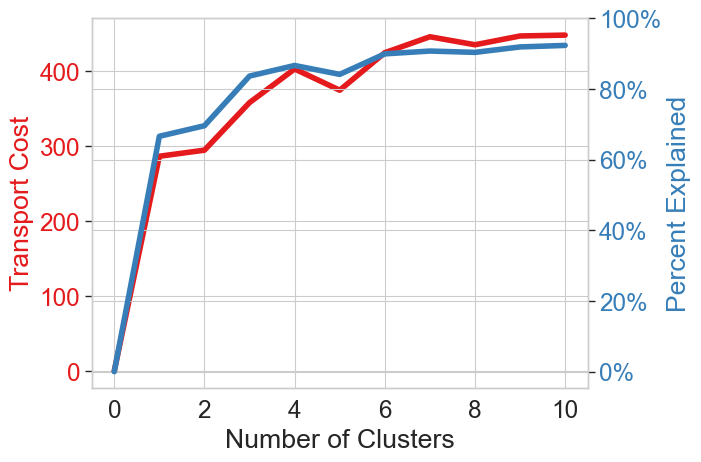

In [11]:
# Create Plot
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Number of Clusters') 
ax1.set_ylabel('Transport Cost', color = pal[0]) 
ax1.plot(np.arange(max_clusters+1), pars, color = pal[0],
         **{k:v for (k,v) in line_parms.items() if k != 'color'})  
ax1.tick_params(axis ='y', labelcolor = pal[0]) 
# Adding Twin Axes
ax2 = ax1.twinx() 
ax2.set_ylabel('Percent Explained', color = pal[1]) 
ax2.plot(np.arange(max_clusters+1), percent_explained, color = pal[1],
         **{k:v for (k,v) in line_parms.items() if k != 'color'}) 
ax2.tick_params(axis ='y', labelcolor = pal[1]) 
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_ylim(None, 100)


print(f'Results with splitting on {split_on}:')
if save_figures: plt.savefig(
    figure_dir / f'logitics_data_on{split_on}--clustering-results.{save_parms["format"]}',
    **save_parms
    )
plt.show()

In [20]:
nba_dict = {}
for record_idx in range(max_clusters):
    cluster_record = cluster_histories[record_idx]
    Z_clusters = cluster_record['Z_clusters']
    labels = cluster_record['labels']
    n_clusters = cluster_record['n_clusters']
    tgt = f'{instance_2}'
    src = f'{instance_1}'
    nba_dict[record_idx] = {}
    print(f'Starting {n_clusters} cluster results:')
    with np.printoptions(precision=3, suppress=True):
        for cluster_idx in range(n_clusters):
            print(f'\tCluster: {cluster_idx}')
            print(f'\t\t         Names={[name[:3] for name in feature_names]}')
            print(f'\t\t   {src}_mean={X[cluster_idx==labels].mean(axis=0)}')
            print(f'\t\tT({tgt})_mean={Z_clusters[cluster_idx==labels].mean(axis=0)}')
            nba_dict[record_idx][cluster_idx] = {}

            nba_dict[record_idx][cluster_idx]['src_means'] = X[cluster_idx==labels].mean(axis=0)
            nba_dict[record_idx][cluster_idx]['trg_means'] = Z_clusters[cluster_idx==labels].mean(axis=0)

        print()

      

Starting 1 cluster results:
	Cluster: 0
		         Names=['Age', 'Gam', 'Net']
		   GSW_mean=[27.742 13.909 33.409]
		T(POR)_mean=[ 27.606   5.856 -11.833]

Starting 2 cluster results:
	Cluster: 0
		         Names=['Age', 'Gam', 'Net']
		   GSW_mean=[31.046 15.369 52.323]
		T(POR)_mean=[31.062  6.4   -5.477]
	Cluster: 1
		         Names=['Age', 'Gam', 'Net']
		   GSW_mean=[24.537 12.493 15.06 ]
		T(POR)_mean=[ 24.254   5.328 -18.   ]

Starting 3 cluster results:
	Cluster: 0
		         Names=['Age', 'Gam', 'Net']
		   GSW_mean=[31.372 11.558  5.442]
		T(POR)_mean=[ 32.907   4.047 -21.698]
	Cluster: 1
		         Names=['Age', 'Gam', 'Net']
		   GSW_mean=[23.882 11.235  3.02 ]
		T(POR)_mean=[ 23.98    5.647 -21.922]
	Cluster: 2
		         Names=['Age', 'Gam', 'Net']
		   GSW_mean=[ 28.816  20.158 105.842]
		T(POR)_mean=[26.474  8.184 12.868]

Starting 4 cluster results:
	Cluster: 0
		         Names=['Age', 'Gam', 'Net']
		   GSW_mean=[24.128  9.319 -3.383]
		T(POR)_mean=[ 25.021   4.936 -

In [19]:
# Assuming max_clusters and nba_dict are predefined elsewhere in your script
vis_clusters = max_clusters
total_distance = []
attributes_list_names = feature_names

# Initialize differences for each cluster
for cluster_idx in range(0, vis_clusters):
    nba_dict[vis_clusters-1][cluster_idx]["differences"] = {}

# Calculate distances for all clusters and attributes
for cluster_idx in range(0, vis_clusters):
    for i, attribute in enumerate(attributes_list_names):
        val_0 = nba_dict[vis_clusters-1][cluster_idx]['src_means'][i]
        val_1 = nba_dict[vis_clusters-1][cluster_idx]['trg_means'][i]
        nba_dict[vis_clusters-1][cluster_idx]["differences"][attribute] = abs(val_1 - val_0)

    # Calculate the total distance for the cluster
    total_distance.append(np.sqrt(sum((nba_dict[vis_clusters-1][cluster_idx]["differences"][attribute]) ** 2 for attribute in attributes_list_names)))

# Create a DataFrame with the calculated differences
distances = pd.DataFrame({
    'Cluster': range(vis_clusters),
    'Total_distance': total_distance
})

# Add each attribute's differences as a separate column
for attribute in attributes_list_names:
    distances[attribute] = [nba_dict[vis_clusters-1][cluster_idx]["differences"][attribute] for cluster_idx in range(vis_clusters)]

# Sort distances by total distance
distances = distances.sort_values(by='Total_distance')

display(distances)

output_path = f'./NBA_results/distance_from_{instance_1}.csv'
distances.to_csv(output_path, index=False)


,Cluster,Total_distance,Age,GamesPlayed,NetScoreOfPlayer
6,6,17.459159,0.666667,4.200000,16.933333
9,9,20.034443,3.312500,3.875000,19.375000
5,5,20.606147,1.625000,1.312500,20.500000
1,1,26.184059,0.666667,7.000000,25.222222
8,8,31.765732,0.555556,8.666667,30.555556
4,4,34.615948,3.416667,11.416667,32.500000
2,2,43.661830,1.272727,9.727273,42.545455
0,0,62.660571,1.818182,13.818182,61.090909
3,3,103.745847,4.470588,15.588235,102.470588
7,7,147.408221,2.857143,5.285714,147.285714


In [17]:
# ergonomic blank space : ) 






























































